# File Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
# import cartopy
import math
import sys
import os
import itertools

In [2]:
# !pip install cartopy

### Create supporting Functions

In [3]:
def find_closest_site(lat,long,df_sites):
    '''
    
    '''
    df_sites['lat-loc'] = np.abs(df_sites.lat-lat)
    df_sites['long-loc'] = np.abs(df_sites.long-long)
    df_sites['distance'] = [np.sqrt(x**2+y**2) for x,y in zip(df_sites['lat-loc'],df_sites['long-loc'])]
    closest_site = df_sites[df_sites.distance==np.min(df_sites['distance'])]
#     closest_site_id = closest_site.reset_index().loc[0,'site']
    
    closest_site = closest_site.rename(columns={'lat':'closest_lat','long':'closest_long'})
    
    return(closest_site)

In [4]:
list_of_locations = \
    {'Petone Beach':{'lat':-41.228661,'long':174.876312},
    'Auckland':{'lat':-36.84307,'long':174.76946}, # TG https://www.psmsl.org/data/obtaining/stations/217.php
    'Pikowai':{'lat':-37.85413,'long':176.662991},
    'Napier Beach':{'lat':-39.50317,'long':176.919780},
    'Christchurch':{'lat':-43.507015,'long':172.732076}, #  (New Brighton Pier)
    'Dunedin':{'lat':-45.878581,'long':170.513456}, # (close to The Octagon)
    'Granity':{'lat':-41.630459,'long':171.851324},
    'Bluff':{'lat':-46.603985,'long':168.352791}, # (Bluff Camping Ground)
    'Muriwai':{'lat':-36.8,'long':174.3},
    'Paraparaumu Beach':{'lat':-40.88089,'long':174.9848},
    'Tairua Beach':{'lat':-36.99,'long':175.862},
    'Orewa':{'lat':-36.5,'long':174.9},
    'Napier Beach North':{'lat':-39.477391,'long':176.884160},
    'Napier Beach South':{'lat':-39.639662,'long':177.000827},
    'Mokomoko inlet':{'lat':-46.537,'long':168.282}, # new data for csv
    'Pounawaea':{'lat':-46.478,'long':169.688},
    'Dunedin Harbourside':{'lat':-45.891283,'long':170.511807},
    'Dunedin St Kilda':{'lat':-45.908870,'long':170.511604}
     
    }


# NZ SLR points for Richard

In [5]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp,colour in zip(rcps,colours):

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)
        
        # Load the data
        ds = netCDF4.Dataset(file)
            
        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])
        
        # Create a dataframe of the site locations
        site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Get a dataframe of all the different locations
        df_locations = pd.DataFrame(list_of_locations).T
        df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_locations.iterrows()])
        df_locations.index = df_locations.index.set_names(['location'])
        df_sites.index = df_sites.index.set_names(['site_ids'])
        df_locations.reset_index(inplace=True)
        df_sites.reset_index(inplace=True,drop=True)
        df_locations = df_locations.join(df_sites)
        
        quantiles_across_sites = {}
            
        for index,row in df_locations.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]

            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
                    'location':row.location,
                    'closest_lat':row.closest_lat,
                    'closest_long':row.closest_long,
                    'colour':colour
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


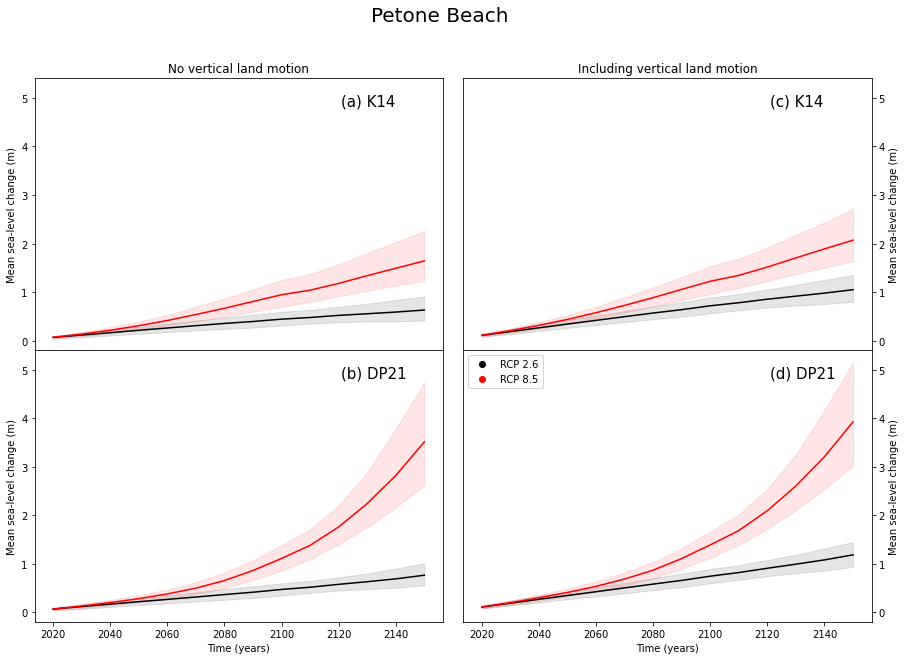

In [6]:
# Set up the figure
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0,wspace=0.05)

ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(1,0))
ax3 = plt.subplot2grid((2,2),(0,1))
ax4 = plt.subplot2grid((2,2),(1,1))

site = 2494

def plot_slr_scenarios(scenario_name,ax):
    '''
    '''
    for rcp,site_dict in AIS_scenarios[scenario_name].items():
        
        quantile_dict = site_dict['quantiles_dict'][site]
        
        ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                c=quantile_dict['colour'])
        ax.fill_between(x=list(quantile_dict['lower'].year),
                         y1=list(quantile_dict['lower'].SLR/1000),
                         y2=list(quantile_dict['upper'].SLR/1000),
                         zorder=-1000,
                         color=quantile_dict['colour'],
                         alpha=0.1)
    return(ax)

# plot the results
ax1 = plot_slr_scenarios('k14',ax1)
ax2 = plot_slr_scenarios('dp21',ax2)
ax3 = plot_slr_scenarios('k14v',ax3)
ax4 = plot_slr_scenarios('dp21v',ax4)
  
y_min = np.min([np.min(ax.get_ylim()) for ax in [ax1,ax2,ax3,ax4]])
y_max = np.max([np.max(ax.get_ylim()) for ax in [ax1,ax2,ax3,ax4]])    
    
# Format the graph
for ax,label in zip([ax1,ax2,ax3,ax4],['(a) K14','(b) DP21','(c) K14','(d) DP21']):
    ax.set_ylabel('Mean sea-level change (m)')
    ax.set_ylim([y_min,y_max])
    ax.text(x=np.max(ax.get_xlim())-0.25*np.diff(ax.get_xlim())[0],
            y=np.max(ax.get_ylim())-0.1*np.diff(ax.get_ylim())[0],
            s=label,fontsize=15)
    
for ax in [ax3,ax4]:
    ax.yaxis.set_label_position('right')
    
for ax in [ax2,ax4]:
    ax.set_xlabel('Time (years)')

for ax in [ax3,ax4]:
    ax.yaxis.tick_right()
    
for ax in [ax1,ax3]:
    ax.set_xticklabels([])
    
# for ax in [ax3,ax4]:
#     ax.set_yticklabels([])
    
ax1.set_title('No vertical land motion')
ax3.set_title('Including vertical land motion')

# for ax in [ax1,ax3]:
#     ax.text(x=2020,y=np.max(ax1.get_ylim())-0.2*np.mean(ax1.get_ylim()),s='k14',fontsize=15)

# for ax in [ax2,ax4]:
#     ax.text(x=2020,y=np.max(ax3.get_ylim())-0.2*np.mean(ax3.get_ylim()),s='dp21',fontsize=15)

l1 = plt.scatter([],[],c='k')
l2 = plt.scatter([],[],c='r')

ax4.legend([l1,l2],['RCP 2.6','RCP 8.5'],loc='upper left')

fig.suptitle(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],fontsize=20)

plt.show()

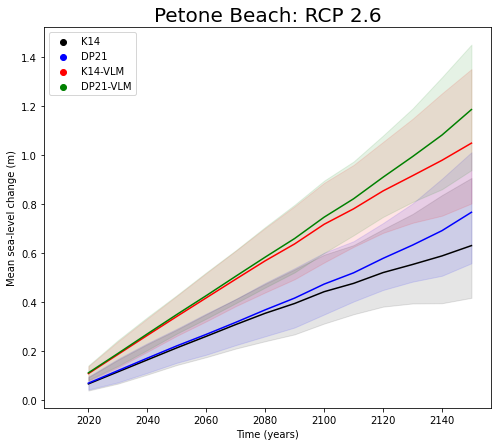

In [7]:
# Set up the figure
fig = plt.figure(figsize=(8,7))
plt.subplots_adjust(hspace=0,wspace=0.05)

ax1 = plt.subplot2grid((1,1),(0,0))

site = 2494

def plot_slr_scenarios(scenario_name,ax,col,output_list):
    '''
    '''
    for rcp,site_dict in AIS_scenarios[scenario_name].items():
        
        quantile_dict = site_dict['quantiles_dict'][site]
        
        if rcp=='26':
            pass
        else:
            continue
        
        output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                c=col)
        ax.fill_between(x=list(quantile_dict['lower'].year),
                         y1=list(quantile_dict['lower'].SLR/1000),
                         y2=list(quantile_dict['upper'].SLR/1000),
                         zorder=-1000,
                         color=col,
                         alpha=0.1)
        output_list.append(output)
        
    return(ax,output_list)

output_list = []

# plot the results
ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
ax1,output_list = plot_slr_scenarios('dp21',ax1,'b',output_list)
ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
ax1,output_list = plot_slr_scenarios('dp21v',ax1,'g',output_list)

    
# Format the graph
for ax,label in zip([ax1,ax2],['(a) K14']):
    ax.set_ylabel('Mean sea-level change (m)')
    
for ax in [ax1]:
    ax.set_xlabel('Time (years)')
    ax.set_xlim([2005,np.max(ax.get_xlim())])

l1 = plt.scatter([],[],c='k')
l2 = plt.scatter([],[],c='b')
l3 = plt.scatter([],[],c='r')
l4 = plt.scatter([],[],c='g')

ax1.legend([l1,l2,l3,l4],['K14','DP21','K14-VLM','DP21-VLM'],loc='upper left')

ax1.set_title(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location']+': RCP 2.6',fontsize=20)

plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],'rcp26'),dpi=300)

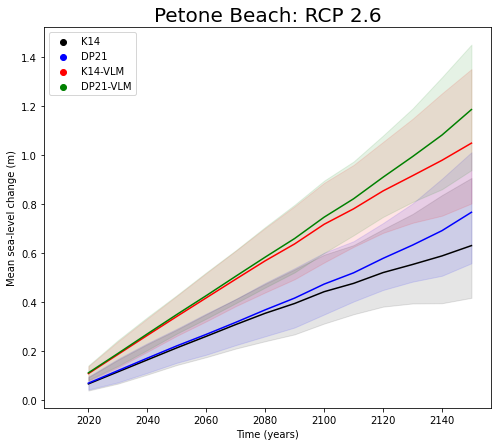

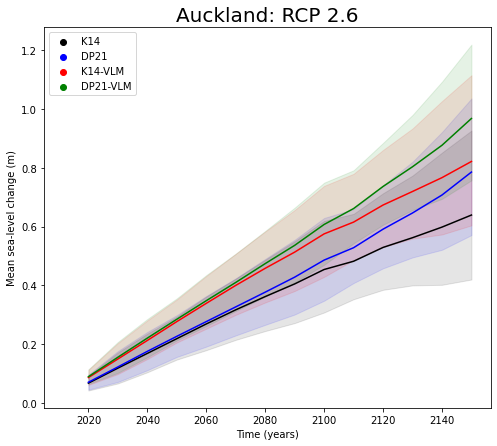

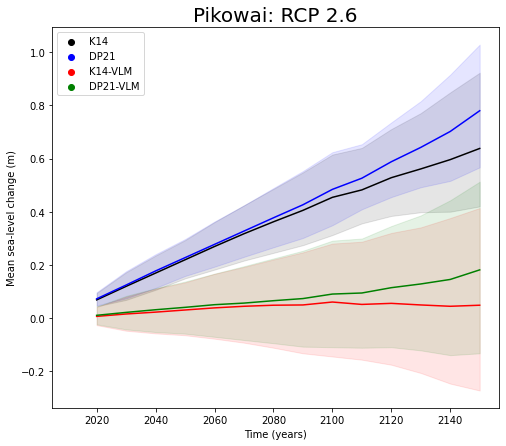

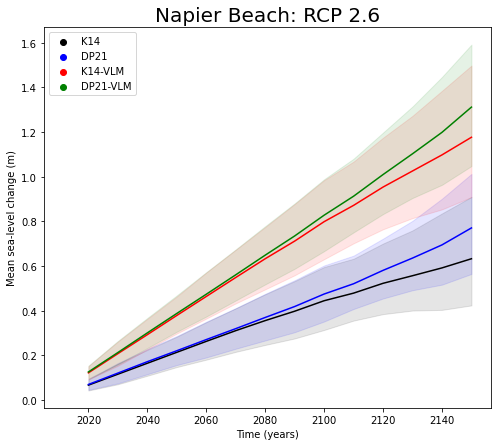

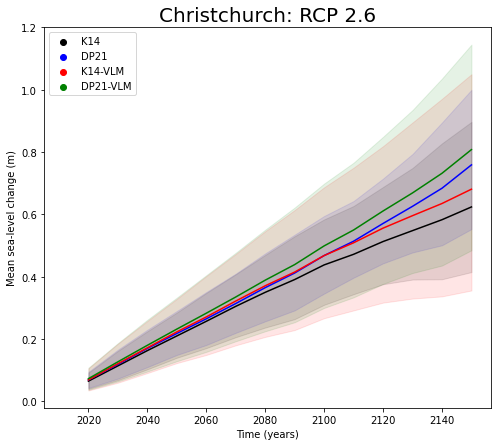

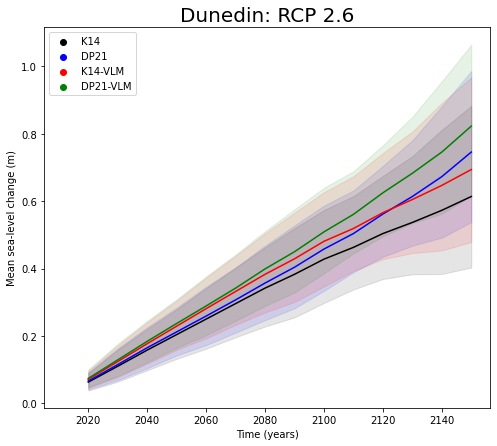

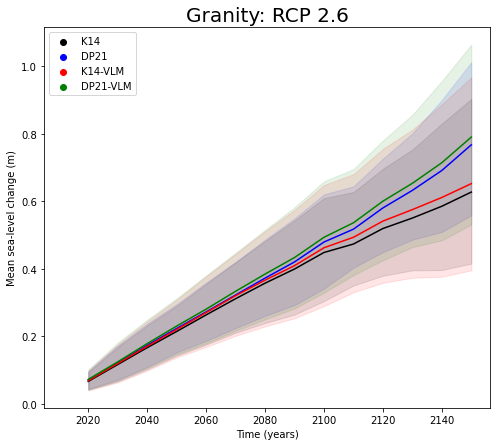

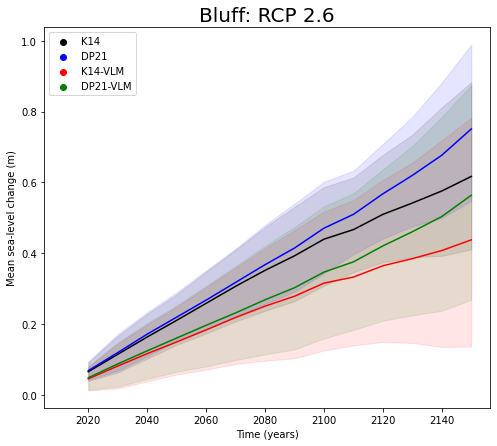

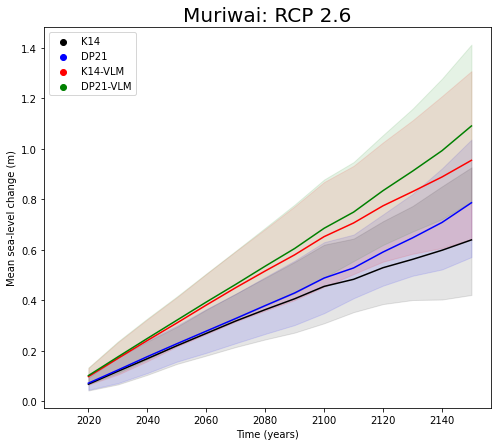

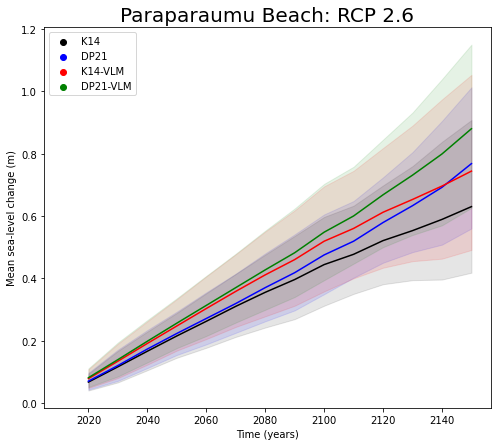

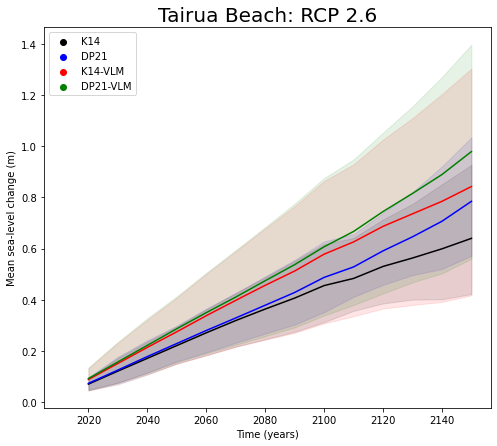

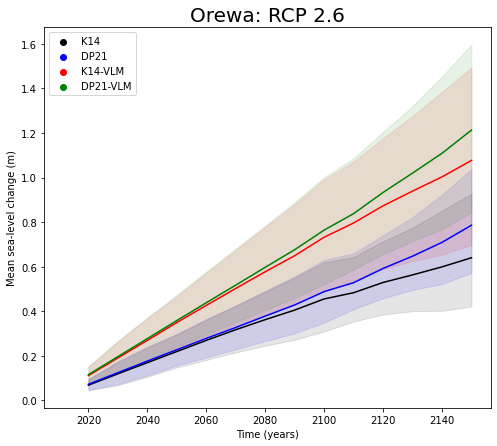

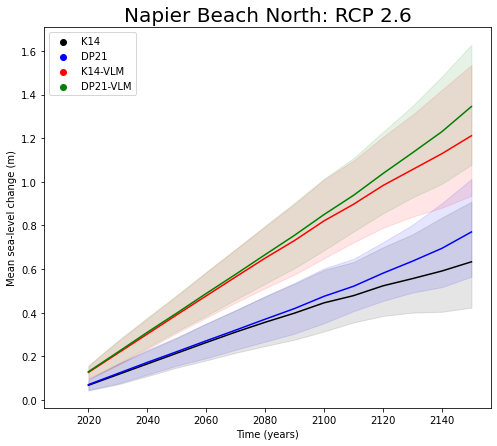

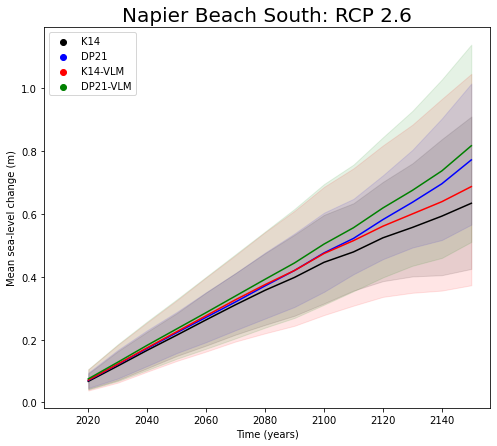

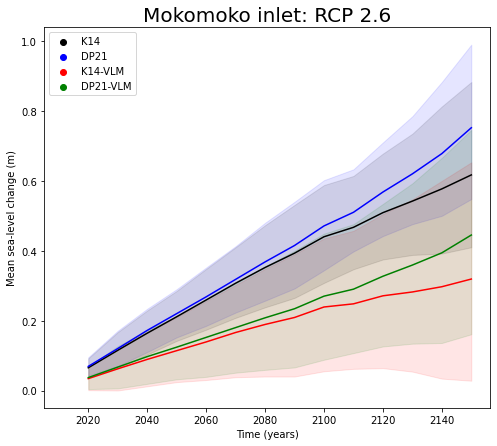

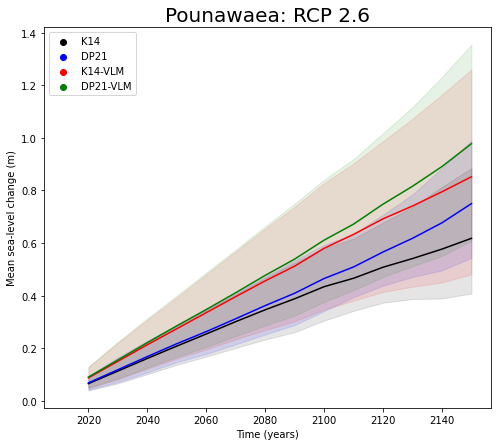

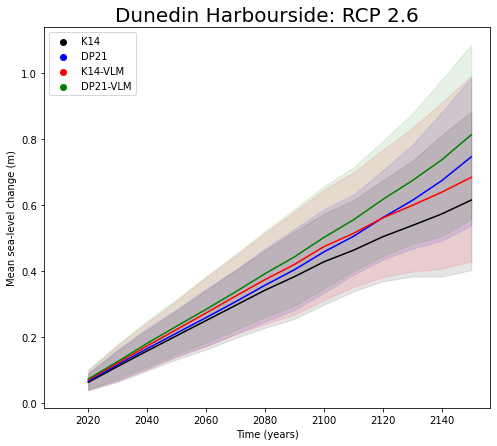

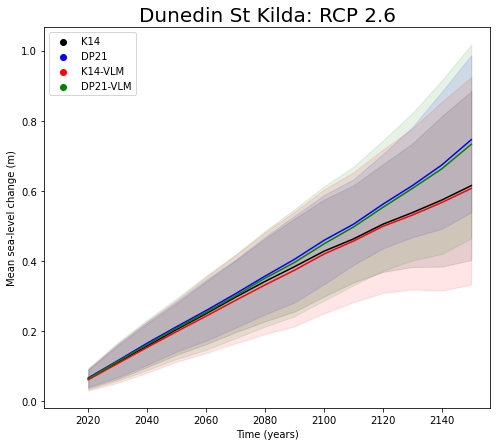

In [8]:

for site in df_locations.site:
    # Set up the figure
    fig = plt.figure(figsize=(8,7))
    plt.subplots_adjust(hspace=0,wspace=0.05)

    ax1 = plt.subplot2grid((1,1),(0,0))

    def plot_slr_scenarios(scenario_name,ax,col,output_list):
        '''
        '''
        for rcp,site_dict in AIS_scenarios[scenario_name].items():

            quantile_dict = site_dict['quantiles_dict'][site]

            if rcp=='26':
                pass
            else:
                continue

            output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                    c=col)
            ax.fill_between(x=list(quantile_dict['lower'].year),
                             y1=list(quantile_dict['lower'].SLR/1000),
                             y2=list(quantile_dict['upper'].SLR/1000),
                             zorder=-1000,
                             color=col,
                             alpha=0.1)
            output_list.append(output)

        return(ax,output_list)

    output_list = []

    # plot the results
    ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
    ax1,output_list = plot_slr_scenarios('dp21',ax1,'b',output_list)
    ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
    ax1,output_list = plot_slr_scenarios('dp21v',ax1,'g',output_list)


    # Format the graph
    for ax,label in zip([ax1,ax2],['(a) K14']):
        ax.set_ylabel('Mean sea-level change (m)')

    for ax in [ax1]:
        ax.set_xlabel('Time (years)')
        ax.set_xlim([2005,np.max(ax.get_xlim())])

    l1 = plt.scatter([],[],c='k')
    l2 = plt.scatter([],[],c='b')
    l3 = plt.scatter([],[],c='r')
    l4 = plt.scatter([],[],c='g')

    ax1.legend([l1,l2,l3,l4],['K14','DP21','K14-VLM','DP21-VLM'],loc='upper left')

    ax1.set_title(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location']+': RCP 2.6',fontsize=20)

    plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['26']['quantiles_dict'][site]['location'],'rcp26'),dpi=300)

# RCP 8.5

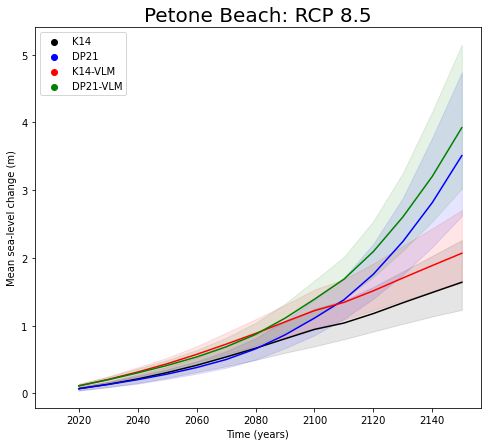

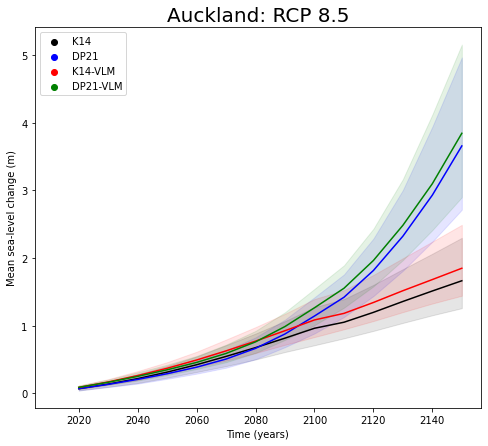

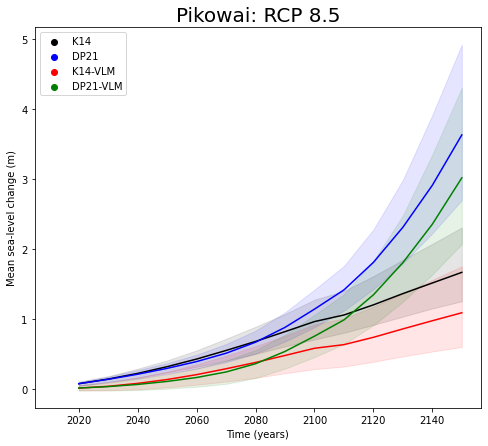

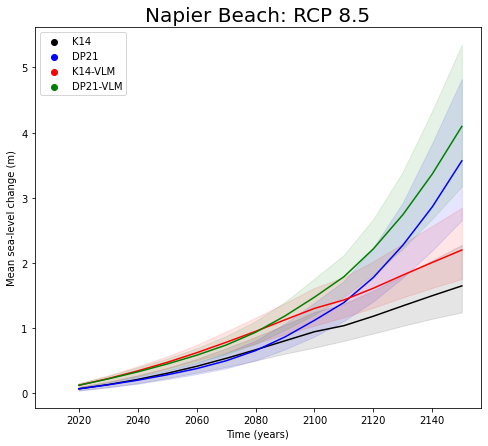

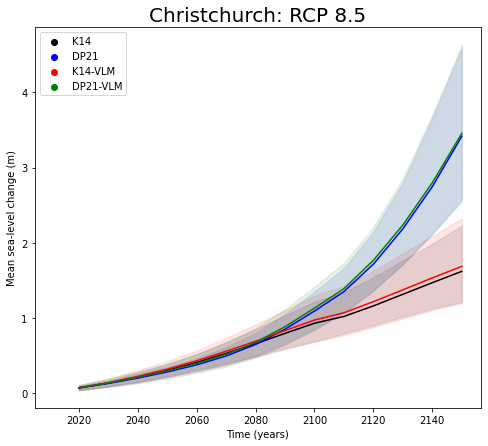

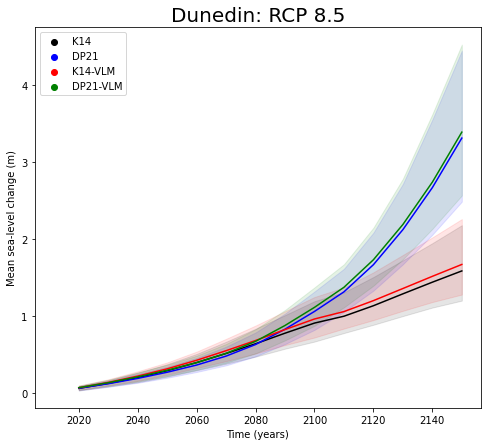

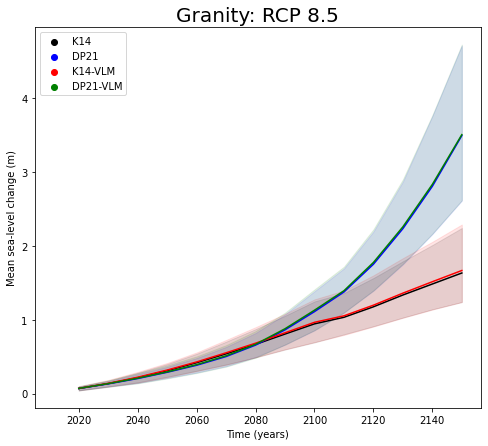

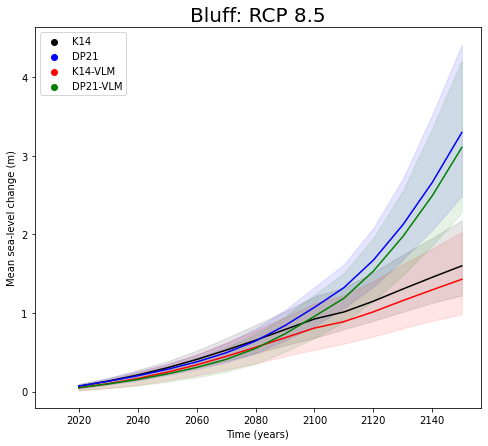

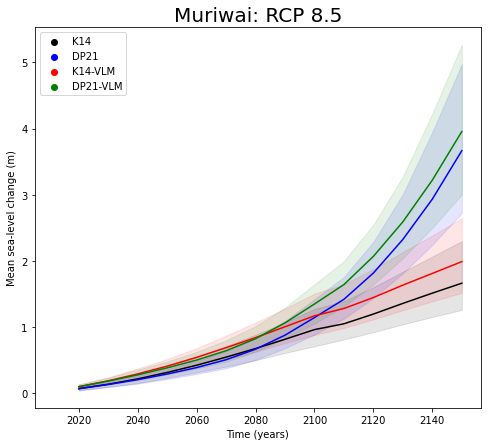

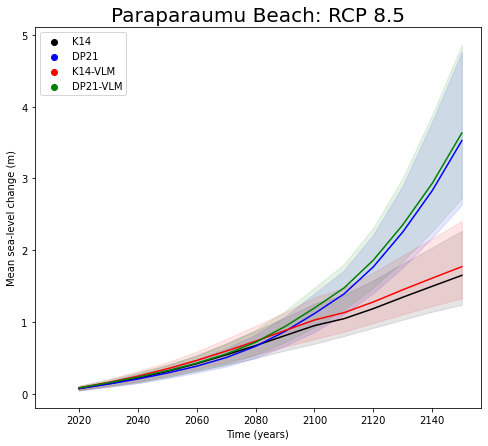

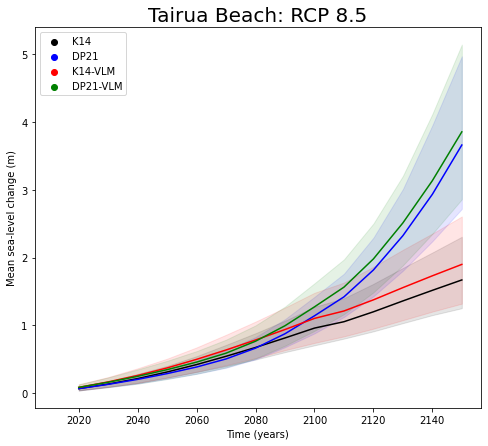

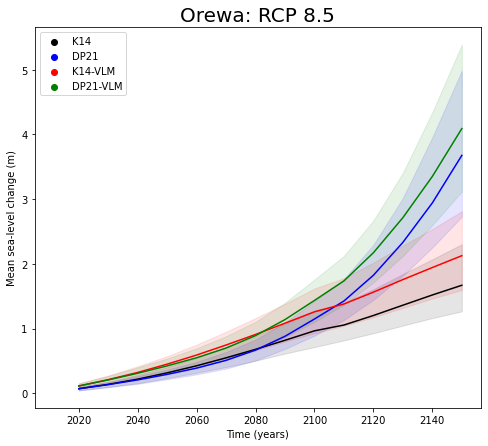

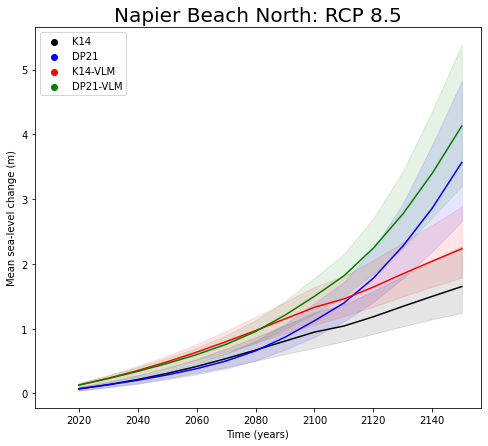

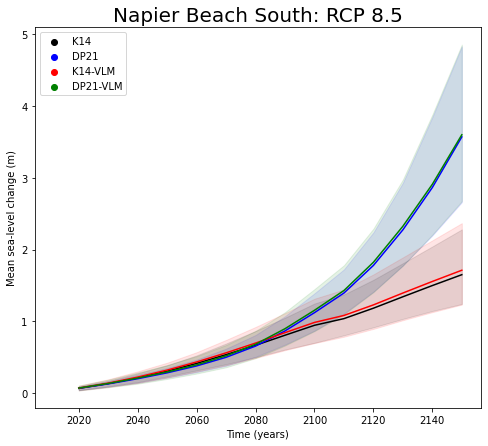

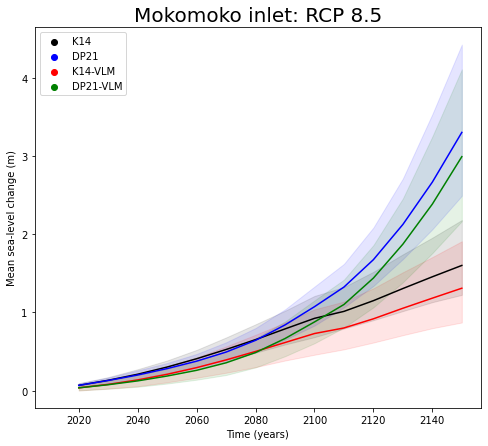

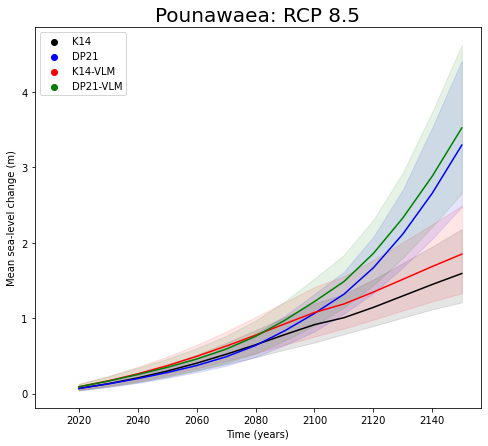

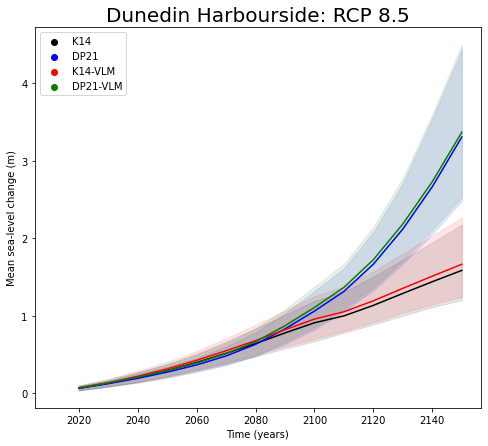

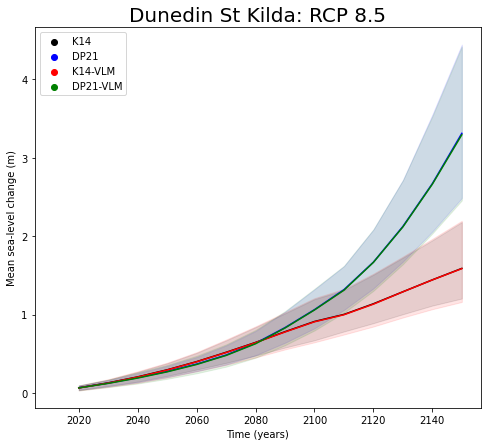

In [9]:

for site in df_locations.site:
    # Set up the figure
    fig = plt.figure(figsize=(8,7))
    plt.subplots_adjust(hspace=0,wspace=0.05)

    ax1 = plt.subplot2grid((1,1),(0,0))

    def plot_slr_scenarios(scenario_name,ax,col,output_list):
        '''
        '''
        for rcp,site_dict in AIS_scenarios[scenario_name].items():

            quantile_dict = site_dict['quantiles_dict'][site]

            if rcp=='85':
                pass
            else:
                continue

            output, = ax.plot(quantile_dict['median'].year,quantile_dict['median'].SLR/1000,
                    c=col)
            ax.fill_between(x=list(quantile_dict['lower'].year),
                             y1=list(quantile_dict['lower'].SLR/1000),
                             y2=list(quantile_dict['upper'].SLR/1000),
                             zorder=-1000,
                             color=col,
                             alpha=0.1)
            output_list.append(output)

        return(ax,output_list)

    output_list = []

    # plot the results
    ax1,output_list = plot_slr_scenarios('k14',ax1,'k',output_list)
    ax1,output_list = plot_slr_scenarios('dp21',ax1,'b',output_list)
    ax1,output_list = plot_slr_scenarios('k14v',ax1,'r',output_list)
    ax1,output_list = plot_slr_scenarios('dp21v',ax1,'g',output_list)


    # Format the graph
    for ax,label in zip([ax1,ax2],['(a) K14']):
        ax.set_ylabel('Mean sea-level change (m)')

    for ax in [ax1]:
        ax.set_xlabel('Time (years)')
        ax.set_xlim([2005,np.max(ax.get_xlim())])

    l1 = plt.scatter([],[],c='k')
    l2 = plt.scatter([],[],c='b')
    l3 = plt.scatter([],[],c='r')
    l4 = plt.scatter([],[],c='g')

    ax1.legend([l1,l2,l3,l4],['K14','DP21','K14-VLM','DP21-VLM'],loc='upper left')

    ax1.set_title(AIS_scenarios['dp21']['85']['quantiles_dict'][site]['location']+': RCP 8.5',fontsize=20)

    plt.savefig('figures/{}_{}.png'.format(AIS_scenarios['dp21']['85']['quantiles_dict'][site]['location'],'rcp85'),dpi=300)

# get data for students

In [10]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "45",
        "60",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r',
        'b',
        'g'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp,colour in zip(rcps,colours):

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

        # Load the data
        try:
            ds = netCDF4.Dataset(file)
        except:
            continue

        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])
        
        # Create a dataframe of the site locations
        site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Get a dataframe of all the different locations
        df_locations = pd.DataFrame(list_of_locations).T
        df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_locations.iterrows()])
        df_locations.index = df_locations.index.set_names(['location'])
        df_sites.index = df_sites.index.set_names(['site_ids'])
        df_locations.reset_index(inplace=True)
        df_sites.reset_index(inplace=True,drop=True)
        df_locations = df_locations.join(df_sites)
        
        quantiles_across_sites = {}
            
        for index,row in df_locations.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]

            print(row)
            
            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
                    'location':row.location,
                    'closest_lat':row.closest_lat,
                    'closest_long':row.closest_long,
                    'colour':colour
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

location        Petone Beach
lat               -41.228661
long              174.876312
closest_lat       -41.230698
closest_long       174.88443
site                    2494
lat-loc             0.002037
long-loc            0.008118
distance            0.008369
Name: 0, dtype: object
location          Auckland
lat              -36.84307
long             174.76946
closest_lat     -36.843376
closest_long    174.769028
site                  1233
lat-loc           0.000305
long-loc          0.000427
distance          0.000525
Name: 1, dtype: object
location           Pikowai
lat              -37.85413
long            176.662991
closest_lat      -37.85693
closest_long    176.669403
site                  1867
lat-loc             0.0028
long-loc          0.006409
distance          0.006994
Name: 2, dtype: object
location        Napier Beach
lat                -39.50317
long               176.91978
closest_lat       -39.508041
closest_long      176.919189
site                    2276
lat-loc   

In [11]:
def slr_scenarios_data(scenario,site):
    '''
    '''

    df_SLR_predictions = \
        pd.concat([AIS_scenarios[scenario]['26']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp2.6','17_rcp2.6','83_rcp2.6']
    df_time = AIS_scenarios[scenario]['26']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_26 = df_time.join(df_SLR_predictions)
    
    df_SLR_predictions = \
    pd.concat([AIS_scenarios[scenario]['45']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp4.5','17_rcp4.5','83_rcp4.5']
    df_time = AIS_scenarios[scenario]['45']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_45 = df_time.join(df_SLR_predictions)
    
    try:
        df_SLR_predictions = \
            pd.concat([AIS_scenarios[scenario]['60']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
        df_SLR_predictions.columns = ['50_rcp6.0','17_rcp6.0','83_rcp6.0']
        df_time = AIS_scenarios[scenario]['60']['quantiles_dict'][site]['median'][['year']]
        df_SLR_predictions_60 = df_time.join(df_SLR_predictions)
    except:
        pass
    
    df_SLR_predictions = \
        pd.concat([AIS_scenarios[scenario]['85']['quantiles_dict'][site][key]['SLR'] for key in ['median','lower','upper']],axis=1)
    df_SLR_predictions.columns = ['50_rcp8.5','17_rcp8.5','83_rcp8.5']
    df_time = AIS_scenarios[scenario]['85']['quantiles_dict'][site]['median'][['year']]
    df_SLR_predictions_85 = df_time.join(df_SLR_predictions)

    df_SLR_predictions_1 = pd.merge(df_SLR_predictions_26,df_SLR_predictions_45,on='year',how='outer')
    try:
        df_SLR_predictions_2 = pd.merge(df_SLR_predictions_60,df_SLR_predictions_85,on='year',how='outer')
    except:
        print(scenario,site)
        df_SLR_predictions_2 = df_SLR_predictions_85
        
    df_SLR_predictions = pd.merge(df_SLR_predictions_1,df_SLR_predictions_2,on='year',how='outer')
    
    return(df_SLR_predictions)
    

In [12]:
# slr_scenarios_data('k14',3338)
# slr_scenarios_data('k14',2584)
# slr_scenarios_data('k14',1648)
# slr_scenarios_data('k14',730)

# rcps = ['26','85']
scenarios = ['k14','dp21','k14v','dp21v']
sites = [5012,4846,4723,4779]

df_permutations = pd.DataFrame([r for r in itertools.product(scenarios, sites)])
df_permutations.columns = ['AIS','site_number']

for index,row in df_permutations.iterrows():
    slr_scenarios_data(row.AIS,row.site_number).to_csv("processed_data/{}_{}.csv".format(
        df_locations[df_locations.site==row.site_number].reset_index(drop=True).loc[0,'location'],row.AIS),index=False)



dp21 5012
dp21 4846
dp21 4723
dp21 4779
dp21v 5012
dp21v 4846
dp21v 4723
dp21v 4779


In [13]:
slr_scenarios_data

<function __main__.slr_scenarios_data(scenario, site)>

In [14]:
slr_scenarios_data

<function __main__.slr_scenarios_data(scenario, site)>

In [15]:
# Check for temps

# get file name 
file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

# Load the data
ds = netCDF4.Dataset(file)

# Extract the variables
time = np.array(ds.variables['years'])
lat = np.array(ds.variables['lat'])
long = np.array(ds.variables['lon'])
localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
quantiles = np.array(ds.variables['quantiles'])
site_id = np.array(ds.variables['id'])

In [16]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    description: Total SLR for workflow
    history: Created Wed May  5 18:17:35 2021; Seed Value 1122
    source: FACTS: Post-processed total among available contributors: icesheets-kopp14SROCC-icesheets-rcp85_GIS_localsl.nc,glaciers-kopp14-glaciers-rcp85_localsl.nc,icesheets-dp20-icesheet-rcp85_AIS_localsl.nc,oceandynamics-kopp14-oceandynamics-rcp85_localsl.nc,verticallandmotion-NZInsarGPS-verticallandmotion_localsl.nc,landwaterstorage-ssp-landwaterstorage-rcp85_localsl.nc
    dimensions(sizes): nsites(7435), years(14), quantiles(108)
    variables(dimensions): float32 lat(nsites), float32 lon(nsites), int32 id(nsites), int32 years(years), float32 quantiles(quantiles), int16 localSL_quantiles(quantiles, nsites, years)
    groups: 

# Get Hawke's bay data

In [57]:
# Import new location for hawke's bay
df_hawkes = pd.read_csv('Hawkes_Bay_2km.xyz',header=None,delimiter=' ').rename(columns={0:'long',1:'lat',2:'long_diff',3:'lat_diff'})

In [63]:
# List all AISs used
AISs = [
    "k14",
#     "dp16",
    "dp21",
    "k14v",
#     "dp16v",
    "dp21v"    
]

AIS_scenarios = {}

# Loop over each AIS type
for AIS in AISs:
    # Create list of rcp scenarios to loop over
    rcps = [
        "26",
        "45",
        "60",
        "85"
    ]

    # have one colour per rcp
    colours = [
        'k',
        'r',
        'b',
        'g'
    ]

    # Create an empty dictionary to store the quantile dataframes in
    rcp_scenarios = {}

    # loop over each rcp
    for rcp,colour in zip(rcps,colours):

        # get file name 
        file = "nz_coast/workflows/wf_{}/rcp{}/total-workflow_localsl.nc".format(AIS,rcp,rcp)

        # Load the data
        try:
            ds = netCDF4.Dataset(file)
        except:
            continue

        # Extract the variables
        time = np.array(ds.variables['years'])
        lat = np.array(ds.variables['lat'])
        long = np.array(ds.variables['lon'])
        localSL_quantiles = np.array(ds.variables['localSL_quantiles'])
        quantiles = np.array(ds.variables['quantiles'])
        site_id = np.array(ds.variables['id'])
        
        # Create a dataframe of the site locations
        site_locations = pd.DataFrame({'lat':lat,'long':long,'site':site_id})

        # get some quantiles for plotting (indexing them from the ds quantile list)
        quantile_value = 0.5
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        median_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        median_quantile.index = median_quantile.index.set_names(['site'])
        median_quantile = pd.melt(median_quantile.reset_index(),id_vars='site')
        median_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Lower IPCC likelihood quantile
        quantile_value = 0.17
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        lower_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        lower_quantile.index = lower_quantile.index.set_names(['site'])
        lower_quantile = pd.melt(lower_quantile.reset_index(),id_vars='site')
        lower_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Upper IPCC likelihood quantile
        quantile_value = 0.83
        quantile_index = np.where(quantiles==round((np.min(abs(quantiles-quantile_value))+quantile_value),2))[0][0] ## check the rounding here

        upper_quantile = pd.DataFrame(data=localSL_quantiles[quantile_index,:,:],index=site_id,columns=time)
        upper_quantile.index = upper_quantile.index.set_names(['site'])
        upper_quantile = pd.melt(upper_quantile.reset_index(),id_vars='site')
        upper_quantile.rename(columns={'value':'SLR','variable':'year'},inplace=True)

        # Get a dataframe of all the different locations
#         df_hawkes = pd.DataFrame(list_of_locations).T
        df_sites = pd.concat([find_closest_site(row.lat,row.long,site_locations) for index,row in df_hawkes.iterrows()])
#         df_hawkes.index = df_hawkes.index.set_names(['location'])
        df_sites.index = df_sites.index.set_names(['site_ids'])
#         df_hawkes.reset_index(inplace=True)
        df_sites.reset_index(inplace=True,drop=True)
#         df_hawkes = df_hawkes.join(df_sites)
        
        quantiles_across_sites = {}
            
        for index,row in df_hawkes.iterrows():
            median_quantile_site = median_quantile[median_quantile.site==row.site]
            lower_quantile_site = lower_quantile[lower_quantile.site==row.site]
            upper_quantile_site = upper_quantile[upper_quantile.site==row.site]
            
            quantiles_across_sites.update({
                row.site:{
                    'median':median_quantile_site,
                    'lower':lower_quantile_site,
                    'upper':upper_quantile_site,
#                     'location':row.location,
                    'closest_lat':row.closest_lat,
                    'closest_long':row.closest_long,
                    'colour':colour
                }
            })
            
        rcp_scenarios.update({
            rcp:{
                "quantiles_dict":quantiles_across_sites,
            }
        })
        
    AIS_scenarios.update({
        AIS:rcp_scenarios
    })


In [73]:
# slr_scenarios_data('k14',3338)
# slr_scenarios_data('k14',2584)
# slr_scenarios_data('k14',1648)
# slr_scenarios_data('k14',730)

# rcps = ['26','85']
scenarios = ['k14','dp21','k14v','dp21v']
sites = list(df_sites.site)

df_permutations = pd.DataFrame([r for r in itertools.product(scenarios, sites)])
df_permutations.columns = ['AIS','site_number']

for index,row in df_permutations.iterrows():
    slr_scenarios_data(row.AIS,row.site_number).to_csv("processed_data/hawkes_bay/site{}_{}.csv".format(
        df_hawkes[df_hawkes.site==row.site_number].reset_index(drop=True).loc[0,'site'],row.AIS),index=False)



dp21 2236
dp21 2237
dp21 2238
dp21 2239
dp21 2240
dp21 2241
dp21 2242
dp21 2243
dp21 2244
dp21 2245
dp21 2246
dp21 2247
dp21 2248
dp21 2249
dp21 2250
dp21 2251
dp21 2252
dp21 2253
dp21 2254
dp21 2255
dp21 2256
dp21 2257
dp21 2258
dp21 2259
dp21 2260
dp21 2261
dp21 2262
dp21 2263
dp21 2264
dp21 2265
dp21 2266
dp21 2267
dp21 2268
dp21 2269
dp21 2270
dp21 2271
dp21 2272
dp21 2273
dp21 2274
dp21 2275
dp21 2276
dp21 2277
dp21 2278
dp21 2279
dp21 2280
dp21 2281
dp21 2282
dp21 2283
dp21 2284
dp21 2285
dp21 2286
dp21 2287
dp21 2288
dp21 2289
dp21 2290
dp21 2291
dp21 2292
dp21 2293
dp21 2294
dp21 2295
dp21 2296
dp21 2297
dp21 2298
dp21 2299
dp21 2300
dp21 2301
dp21 2302
dp21 2303
dp21 2304
dp21 2305
dp21 2306
dp21 2307
dp21 2308
dp21 2309
dp21 2310
dp21 2311
dp21 2312
dp21 2313
dp21 2314
dp21 2315
dp21 2316
dp21 2317
dp21 2318
dp21 2319
dp21 2320
dp21 2321
dp21 2322
dp21 2323
dp21 2324
dp21 2325
dp21 2326
dp21 2327
dp21 2328
dp21 2329
dp21 2330
dp21 2331
dp21 2332
dp21 2333
dp21 2334
dp21 2335


In [76]:
df_hawkes_save = df_hawkes[['long','lat','site']].set_index('site')
df_hawkes_save.to_csv('processed_data/hawkes_bay/site_locations.csv')